This Jupyter cell:

1. Reads the FOM values from your log file using regex pattern matching
1. Organizes the data into a structured format
3. Creates 2D heatmaps for each AlN thickness value, showing how FOM varies with block width and height
4. Adds contour lines to better visualize the optimal regions
5. Creates a 3D scatter plot to visualize all data points at once
6. Identifies and highlights the best configuration

You can adjust the path to your log directory if needed. The visualization should help you identify the optimal parameter combinations for your trilayer structure.

Block widths: [0.01 0.05 0.2  0.45]
Block heights: [0.05  0.175 0.3   0.425 0.55 ]
AlN thicknesses: [0.01  0.1   0.35  0.473 0.55  0.85 ]

Best configuration:
Block width: 0.010 μm
Block height: 0.050 μm
AlN thickness: 0.473 μm
FOM value: 0.4900


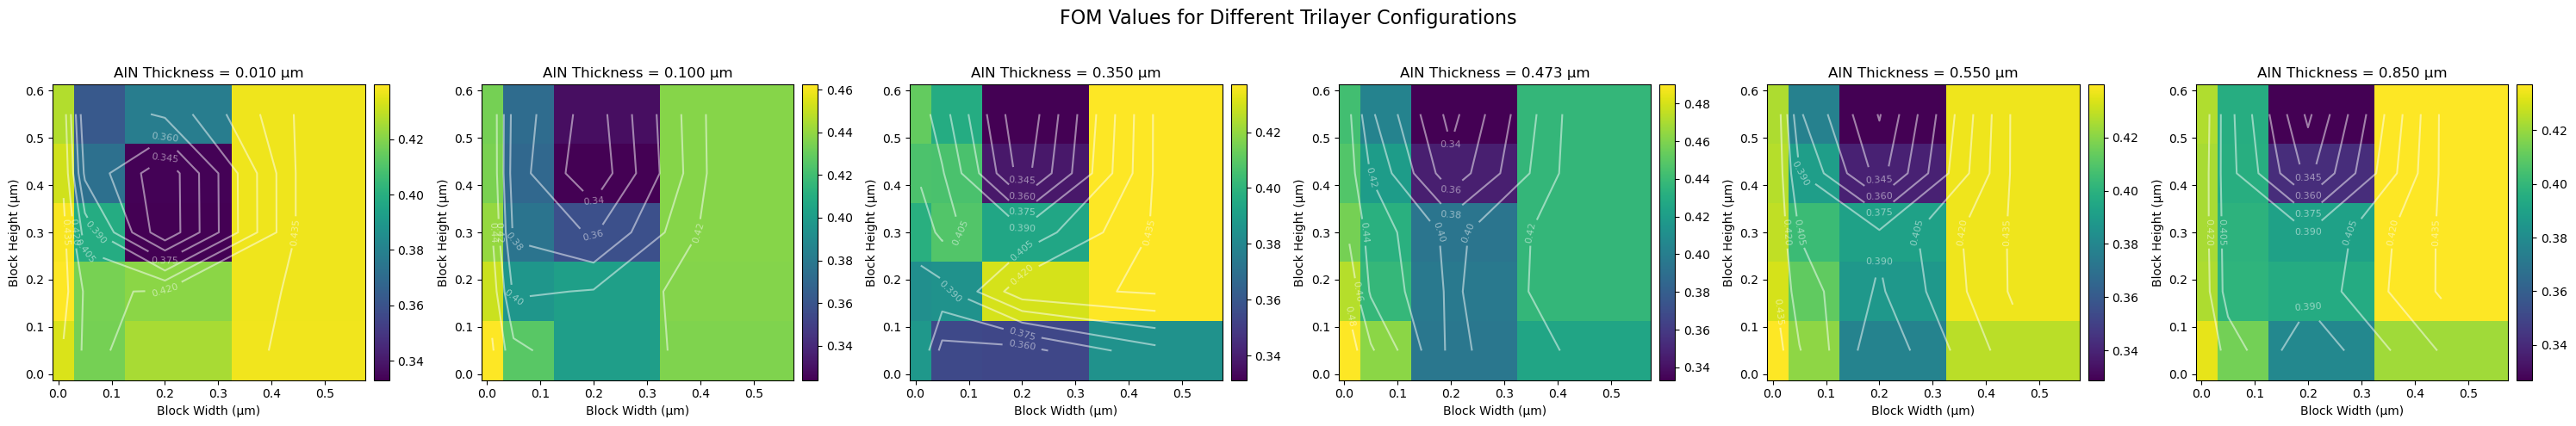

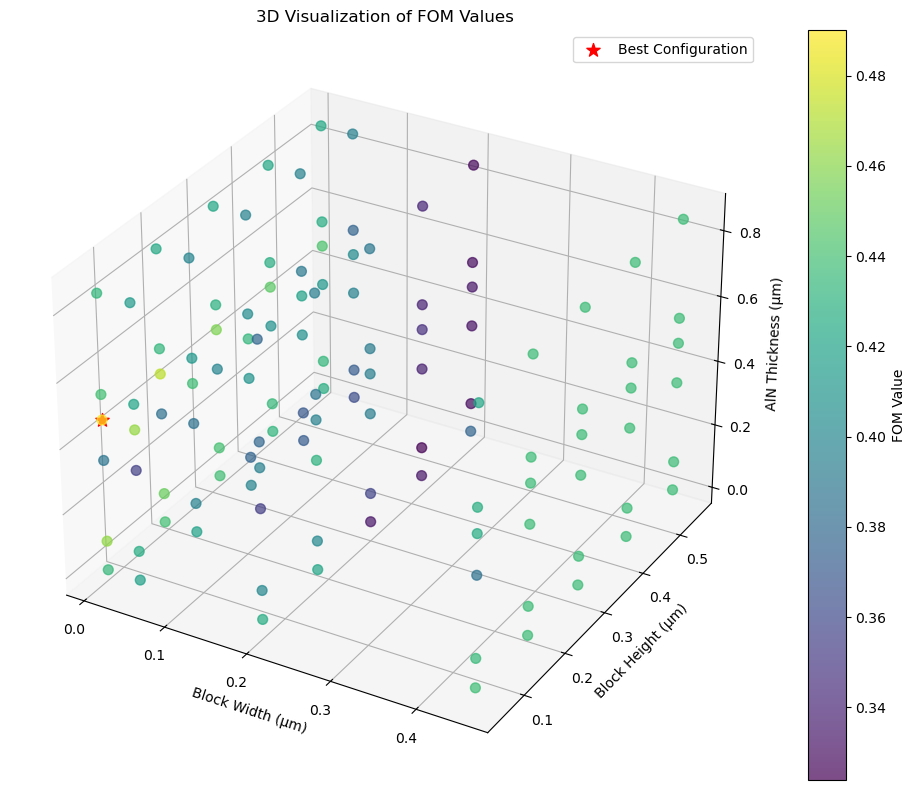

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import seaborn as sns
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Path to your log directory - update this to your actual log path
fom_file = os.path.join('../tracked-logs/def-887bc81e_1', 'fom_values.txt')

# Read the FOM values file
with open(fom_file, 'r') as f:
    content = f.read()

# Parse the data using regex
pattern = r"block_width=([\d.]+), block_height=([\d.]+), AlN_thickness=([\d.]+)\nFOM Value: ([\d.]+)"
matches = re.findall(pattern, content)

# Convert to numeric values and organize data
data = []
for match in matches:
    block_width = float(match[0])
    block_height = float(match[1])
    aln_thickness = float(match[2])
    fom_value = float(match[3])
    data.append((block_width, block_height, aln_thickness, fom_value))

# Convert to numpy array for easier manipulation
data_array = np.array(data)

# Get unique values for each parameter
widths = np.unique(data_array[:, 0])
heights = np.unique(data_array[:, 1])
thicknesses = np.unique(data_array[:, 2])

print(f"Block widths: {widths}")
print(f"Block heights: {heights}")
print(f"AlN thicknesses: {thicknesses}")

# Create a figure with subplots for each AlN thickness
fig, axes = plt.subplots(1, len(thicknesses), figsize=(5*len(thicknesses), 5), squeeze=False)
fig.suptitle('FOM Values for Different Trilayer Configurations', fontsize=16)

# Create heatmaps for each AlN thickness
for i, thickness in enumerate(thicknesses):
    # Filter data for this thickness
    thickness_data = data_array[data_array[:, 2] == thickness]
    
    # Create a 2D grid for the heatmap
    heatmap_data = np.zeros((len(heights), len(widths)))
    
    # Fill the grid with FOM values
    for row in thickness_data:
        w_idx = np.where(widths == row[0])[0][0]
        h_idx = np.where(heights == row[1])[0][0]
        heatmap_data[h_idx, w_idx] = row[3]
    
    # Plot the heatmap
    ax = axes[0, i]
    im = ax.pcolormesh(widths, heights, heatmap_data, cmap='viridis', shading='auto')
    
    # Add contour lines
    contour = ax.contour(widths, heights, heatmap_data, colors='white', alpha=0.5)
    ax.clabel(contour, inline=True, fontsize=8)
    
    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    
    # Set labels
    ax.set_xlabel('Block Width (μm)')
    ax.set_ylabel('Block Height (μm)')
    ax.set_title(f'AlN Thickness = {thickness:.3f} μm')

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Create a 3D scatter plot to visualize all data points
fig2 = plt.figure(figsize=(10, 8))
ax3d = fig2.add_subplot(111, projection='3d')

# Scatter plot with color representing FOM value
scatter = ax3d.scatter(data_array[:, 0], data_array[:, 1], data_array[:, 2], 
                       c=data_array[:, 3], cmap='viridis', s=50, alpha=0.7)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('FOM Value')

# Set labels
ax3d.set_xlabel('Block Width (μm)')
ax3d.set_ylabel('Block Height (μm)')
ax3d.set_zlabel('AlN Thickness (μm)')
ax3d.set_title('3D Visualization of FOM Values')

# Find the best configuration
best_idx = np.argmax(data_array[:, 3])
best_config = data_array[best_idx]
print(f"\nBest configuration:")
print(f"Block width: {best_config[0]:.3f} μm")
print(f"Block height: {best_config[1]:.3f} μm")
print(f"AlN thickness: {best_config[2]:.3f} μm")
print(f"FOM value: {best_config[3]:.4f}")

# Mark the best configuration in the 3D plot
ax3d.scatter([best_config[0]], [best_config[1]], [best_config[2]], 
             color='red', s=100, marker='*', label='Best Configuration')
ax3d.legend()

plt.tight_layout()
plt.show()


This Jupyter cell:

1. Finds all emissivity files in your log directory
2. Extracts the block height, block width, and AlN thickness parameters from the filenames
3. Creates interactive sliders to select specific parameter values
4. Plots:
    * The emissivity profile across wavelengths
    * The spectral power density (emissivity × blackbody radiation)
    * Highlights regions above and below the bandgap wavelength (1.71 μm for 0.726 eV)
5. Calculates and displays a figure of merit (ratio of power below bandgap to total power)
6. Optionally compares the selected configuration with other configurations

The interactive sliders make it easy to explore how different structural parameters affect the emissivity profile. The comparison feature helps you visually identify which configurations perform better for your TPV application.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import sys
from ipywidgets import interact, FloatSlider, fixed

# Add the directory containing ff.py to the Python path
# Assuming ff.py is in the trials directory
trials_dir = os.path.join(os.path.dirname(os.getcwd()), 'trials')
if trials_dir not in sys.path:
    sys.path.append(trials_dir)

# Import the power_ratio function from ff.py
try:
    import ff
    print("Successfully imported ff module")
except ImportError:
    print("Could not import ff module. Please check the path.")
    
    # Define a fallback power_ratio function in case import fails
    def power_ratio(wavelengths, emissivity, T_e, bandgap_ev):
        # Convert bandgap from eV to wavelength in microns
        bandgap_wl = 1.24 / bandgap_ev
        bandgap_idx = np.argmin(np.abs(wavelengths - bandgap_wl))
        
        # Calculate blackbody radiation
        h = 6.626070e-34  # Js Planck's constant
        c = 2.997925e8    # m/s speed of light
        k_B = 1.380649e-23  # J/K Boltzmann constant
        
        # Convert wavelengths to meters for calculation
        wl_m = wavelengths * 1e-6
        
        # Calculate spectral radiance (W/m²/m)
        bb_spectral = (2*h*c**2) / ((np.exp((h*c)/(k_B*T_e*wl_m))-1) * wl_m**5)
        
        # Multiply by emissivity to get spectral power density
        spectral_power = emissivity * bb_spectral
        
        # Calculate power ratio
        power_below_bandgap = np.trapz(spectral_power[:bandgap_idx], wavelengths[:bandgap_idx])
        power_total = np.trapz(spectral_power, wavelengths)
        
        return power_below_bandgap / power_total if power_total > 0 else 0

# Path to your log directory - update this to your actual log path
# log_dir = '../logs/def-eb619965_6'
log_dir = '../tracked-logs/def-887bc81e_1'

# Get all emissivity files
emissivity_files = glob.glob(os.path.join(log_dir, 'emissivity_*.txt'))
print(f"Found {len(emissivity_files)} emissivity files")

# Extract parameters from filenames
params_list = []
for file_path in emissivity_files:
    filename = os.path.basename(file_path)
    # Parse parameters from filename: emissivity_{block_height}H_{block_width}W_{aln_thickness}AlN.txt
    parts = filename.replace('emissivity_', '').replace('.txt', '').split('_')
    
    block_height = float(parts[0].replace('H', ''))
    block_width = float(parts[1].replace('W', ''))
    aln_thickness = float(parts[2].replace('AlN', ''))
    
    params_list.append({
        'block_height': block_height,
        'block_width': block_width,
        'aln_thickness': aln_thickness,
        'file_path': file_path
    })

# Get unique values for each parameter
block_heights = sorted(list(set([p['block_height'] for p in params_list])))
block_widths = sorted(list(set([p['block_width'] for p in params_list])))
aln_thicknesses = sorted(list(set([p['aln_thickness'] for p in params_list])))

print(f"Block heights: {block_heights}")
print(f"Block widths: {block_widths}")
print(f"AlN thicknesses: {aln_thicknesses}")

# Load wavelengths from the simulation parameters
wavelengths = np.linspace(.350, 3, 2651)
wavelengths = wavelengths[(wavelengths != 0.5) & (wavelengths != 1.0)]  # Remove problematic wavelengths

# Determine global axis limits by examining all emissivity data
all_emissivity_data = []
for p in params_list:
    emissivity = np.loadtxt(p['file_path'])
    all_emissivity_data.append(emissivity)

# Calculate global min and max for consistent y-axis
global_min = min(np.min(data) for data in all_emissivity_data)
global_max = max(np.max(data) for data in all_emissivity_data)

# Add a small margin to the limits
y_margin = 0.05 * (global_max - global_min)
global_y_min = max(0, global_min - y_margin)  # Ensure we don't go below 0 for emissivity
global_y_max = global_max + y_margin

# Function to find the closest value in a list
def find_closest(value, options):
    return min(options, key=lambda x: abs(x - value))

# Function to plot emissivity for given parameters
def plot_emissivity(block_height, block_width, aln_thickness, compare=False):
    # Find closest parameter values in our dataset
    h = find_closest(block_height, block_heights)
    w = find_closest(block_width, block_widths)
    t = find_closest(aln_thickness, aln_thicknesses)
    
    # Find the matching file
    matching_params = [p for p in params_list 
                      if abs(p['block_height'] - h) < 1e-5 
                      and abs(p['block_width'] - w) < 1e-5 
                      and abs(p['aln_thickness'] - t) < 1e-5]
    
    if not matching_params:
        print(f"No data found for parameters close to: height={h}, width={w}, thickness={t}")
        return
    
    file_path = matching_params[0]['file_path']
    emissivity = np.loadtxt(file_path)
    
    # Convert to torch tensor if ff.power_ratio expects torch tensors
    try:
        import torch
        emissivity_tensor = torch.tensor(emissivity)
        wavelengths_tensor = torch.tensor(wavelengths)
    except ImportError:
        emissivity_tensor = emissivity
        wavelengths_tensor = wavelengths
    
    plt.figure(figsize=(12, 6))
    
    # Plot emissivity vs wavelength
    plt.subplot(1, 2, 1)
    plt.plot(wavelengths, emissivity, 'b-', linewidth=2)
    plt.xlabel('Wavelength (μm)')
    plt.ylabel('Emissivity')
    plt.title(f'Emissivity Profile\nH={h:.3f}μm, W={w:.3f}μm, AlN={t:.3f}μm')
    plt.grid(True, alpha=0.3)
    
    # Set consistent y-axis limits
    plt.ylim(global_y_min, global_y_max)
    
    # Add vertical line at bandgap wavelength (0.726 eV = ~1.71 μm)
    bandgap_ev = 0.726
    bandgap_wl = 1.24 / bandgap_ev
    plt.axvline(x=bandgap_wl, color='r', linestyle='--', label=f'Bandgap ({bandgap_ev} eV)')
    
    # Highlight regions (below and above bandgap)
    plt.axvspan(wavelengths[0], bandgap_wl, alpha=0.2, color='green', label='Desired emission')
    plt.axvspan(bandgap_wl, wavelengths[-1], alpha=0.2, color='red', label='Undesired emission')
    plt.legend()
    
    # Plot spectral power density (emissivity * blackbody)
    plt.subplot(1, 2, 2)
    
    # Calculate blackbody radiation at T_e = 2073.15K (from your code)
    h_const = 6.626070e-34  # Js Planck's constant
    c_const = 2.997925e8    # m/s speed of light
    k_B = 1.380649e-23  # J/K Boltzmann constant
    T_e = 2073.15     # K emitter temperature
    
    # Convert wavelengths to meters for calculation
    wl_m = wavelengths * 1e-6
    
    # Calculate spectral radiance (W/m²/m)
    bb_spectral = (2*h_const*c_const**2) / ((np.exp((h_const*c_const)/(k_B*T_e*wl_m))-1) * wl_m**5)
    
    # Multiply by emissivity to get spectral power density
    spectral_power = emissivity * bb_spectral
    
    # Normalize for better visualization
    spectral_power = spectral_power / np.max(spectral_power)
    
    plt.plot(wavelengths, spectral_power, 'g-', linewidth=2)
    plt.xlabel('Wavelength (μm)')
    plt.ylabel('Normalized Spectral Power')
    plt.title('Spectral Power Density (Emissivity × Blackbody)')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.05)  # Consistent y-axis for normalized power
    
    # Add vertical line at bandgap wavelength
    plt.axvline(x=bandgap_wl, color='r', linestyle='--', label=f'Bandgap ({bandgap_ev} eV)')
    
    # Highlight regions
    plt.axvspan(wavelengths[0], bandgap_wl, alpha=0.2, color='green', label='Useful power')
    plt.axvspan(bandgap_wl, wavelengths[-1], alpha=0.2, color='red', label='Wasted power')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display FOM using the actual power_ratio function
    import sys
    sys.path.append('../trials')
    import ff
    import torch
    fom = ff.power_ratio(torch.tensor(wavelengths), torch.tensor(emissivity), ff.T_e, .726)#.726
    
    print(f"Figure of Merit (power ratio): {fom:.4f}")
    
    if compare:
        # Compare with other configurations
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot the current configuration
        ax.plot(wavelengths, emissivity, 'b-', linewidth=2, 
                label=f'H={h:.3f}μm, W={w:.3f}μm, AlN={t:.3f}μm')
        
        # Plot a few other configurations for comparison
        colors = ['r', 'g', 'm', 'c', 'y']
        color_idx = 0
        
        # Get some different configurations to compare
        other_params = [p for p in params_list 
                       if not (abs(p['block_height'] - h) < 1e-5 
                              and abs(p['block_width'] - w) < 1e-5 
                              and abs(p['aln_thickness'] - t) < 1e-5)]
        
        # Select a few different configurations (max 5)
        compare_params = other_params[:5] if len(other_params) > 5 else other_params
        
        for p in compare_params:
            other_emissivity = np.loadtxt(p['file_path'])
            ax.plot(wavelengths, other_emissivity, 
                   color=colors[color_idx], linestyle='--', 
                   label=f"H={p['block_height']:.3f}μm, W={p['block_width']:.3f}μm, AlN={p['aln_thickness']:.3f}μm")
            color_idx = (color_idx + 1) % len(colors)
        
        ax.set_xlabel('Wavelength (μm)')
        ax.set_ylabel('Emissivity')
        ax.set_title('Comparison of Different Configurations')
        ax.axvline(x=bandgap_wl, color='k', linestyle='--', label=f'Bandgap ({bandgap_ev} eV)')
        ax.grid(True, alpha=0.3)
        
        # Set consistent y-axis limits for comparison plot
        ax.set_ylim(global_y_min, global_y_max)
        
        # Add shaded regions for below/above bandgap
        ax.axvspan(wavelengths[0], bandgap_wl, alpha=0.1, color='green')
        ax.axvspan(bandgap_wl, wavelengths[-1], alpha=0.1, color='red')
        
        ax.legend(loc='best')
        plt.tight_layout()
        plt.show()
        
        # Also show a comparison of the spectral power densities
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Calculate and plot spectral power for current configuration
        spectral_power = emissivity * bb_spectral
        normalized_power = spectral_power / np.max(spectral_power)
        ax.plot(wavelengths, normalized_power, 'b-', linewidth=2, 
                label=f'H={h:.3f}μm, W={w:.3f}μm, AlN={t:.3f}μm')
        
        # Calculate and plot spectral power for comparison configurations
        color_idx = 0
        for p in compare_params:
            other_emissivity = np.loadtxt(p['file_path'])
            other_spectral_power = other_emissivity * bb_spectral
            other_normalized_power = other_spectral_power / np.max(other_spectral_power)
            ax.plot(wavelengths, other_normalized_power, 
                   color=colors[color_idx], linestyle='--', 
                   label=f"H={p['block_height']:.3f}μm, W={p['block_width']:.3f}μm, AlN={p['aln_thickness']:.3f}μm")
            color_idx = (color_idx + 1) % len(colors)
        
        ax.set_xlabel('Wavelength (μm)')
        ax.set_ylabel('Normalized Spectral Power')
        ax.set_title('Comparison of Different Configurations')
        plt.axvline(x=bandgap_wl, color='k', linestyle='--', label='Bandgap (0.726 eV)')
        plt.grid(True, alpha=0.3)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

# Create interactive widget
interact(
    plot_emissivity,
    block_height=FloatSlider(min=min(block_heights), max=max(block_heights), 
                            step=(max(block_heights)-min(block_heights))/len(block_heights), 
                            value=block_heights[len(block_heights)//2]),
    block_width=FloatSlider(min=min(block_widths), max=max(block_widths), 
                           step=(max(block_widths)-min(block_widths))/len(block_widths), 
                           value=block_widths[len(block_widths)//2]),
    aln_thickness=FloatSlider(min=min(aln_thicknesses), max=max(aln_thicknesses), 
                             step=(max(aln_thicknesses)-min(aln_thicknesses))/len(aln_thicknesses), 
                             value=aln_thicknesses[len(aln_thicknesses)//2]),
    compare=True
);



Successfully imported ff module
Found 120 emissivity files
Block heights: [0.05, 0.175, 0.3, 0.425, 0.55]
Block widths: [0.01, 0.05, 0.2, 0.45]
AlN thicknesses: [0.01, 0.1, 0.35, 0.473, 0.55, 0.85]


interactive(children=(FloatSlider(value=0.3, description='block_height', max=0.55, min=0.05), FloatSlider(valu…

# This code is for reproducing the plots from Zhao's work with the Aluminum Nitride information

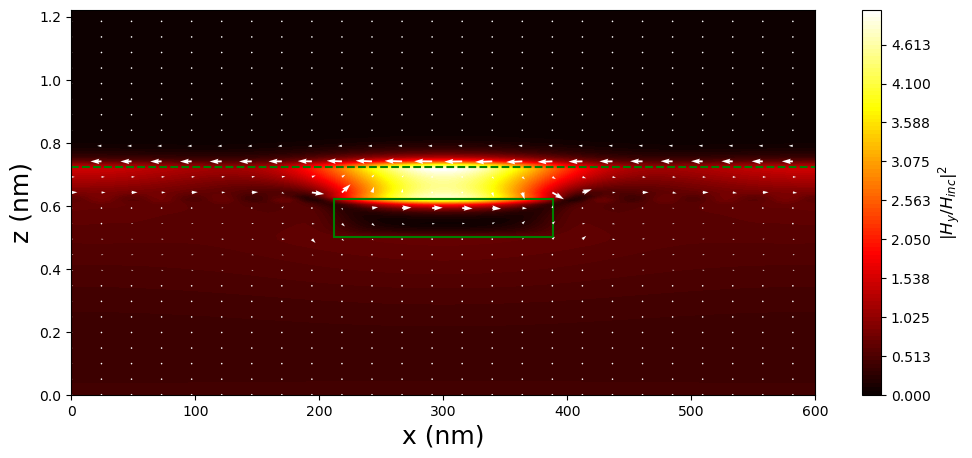

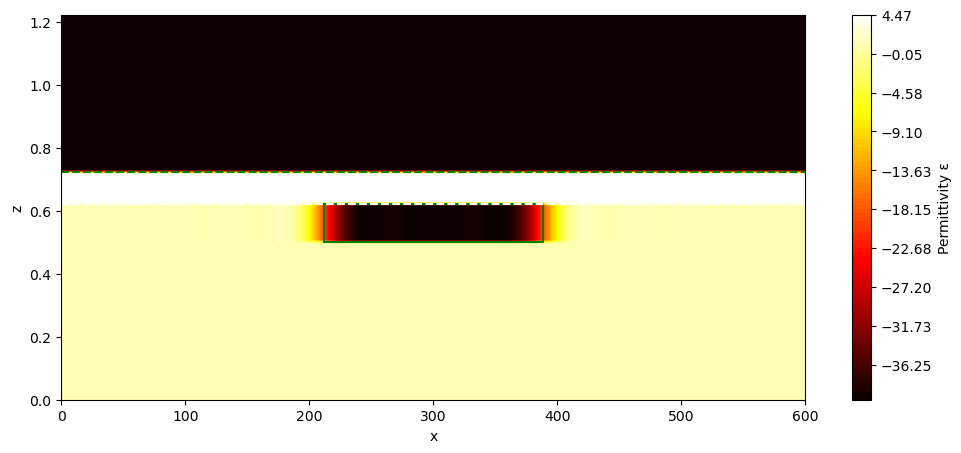

In [72]:
"""
This file simulates trials of the trilayer structure with different width, height, and thickness parameters
"""


import json
import os
import sys
import time
from pathlib import Path

import ff
import matplotlib.pyplot as plt
import numpy as np
import S4
import torch
from tqdm import tqdm
import gc

config = {
    "seeds": {
        "torch": int(52),
        "numpy": int(41)
    },
    "incidence_angle": float(0),
    "image_harmonics": int(25),
    "polarization_angle": float(45),
}

torch.manual_seed(config['seeds']['torch'])
np.random.seed(config['seeds']['numpy'])
fom_file = os.path.join(log_dir, 'fom_values.txt')

wavelengths = torch.linspace(.350, 3, 2651)  # Issue when this goes past 99?

wavelengths = wavelengths[(wavelengths != 0.5) & (wavelengths != 1.0)] # This is necessary due to S4 bugging out at these wavelengths

block_width_list = np.linspace(0.01, (.5-.01)/2, 4)
block_width = block_width_list[1]
block_height_list = np.linspace(0.0, 0.55, 10)
block_height = block_height_list[2]
aln_thickness_list = np.array([0.01, 0.1, 0.35, 0.473, 0.55, 0.85])
current_aln_thickness = aln_thickness_list[1]
top = False

transmitted_power_per_wavelength = torch.zeros((len(wavelengths),))

i_wavelength = 1830-350+1
wavelength = wavelengths[i_wavelength]
S = S4.New(Lattice = .6, NumBasis=config['image_harmonics'])
S.SetOptions(LanczosSmoothing=True)
S.SetMaterial(Name='Vacuum', Epsilon=(1+0j)**2)
S.SetMaterial(Name='W', Epsilon=(ff.w_n[i_wavelength])**2)    # Simple approximate usage
S.SetMaterial(Name='W2', Epsilon=-(ff.w_n[i_wavelength])**2)    # Simple approximate usage
S.SetMaterial(Name='AlN', Epsilon=(ff.aln_n[i_wavelength])**2)
S.AddLayer(Name = 'VacuumAbove', Thickness = .5, Material = 'Vacuum')
if top:
    S.AddLayer(Name = 'Grid0', Thickness = block_height/2, Material = 'Vacuum')
    S.SetRegionRectangle(Layer = 'Grid0', Material = 'AlN', Center = (.3, .3), Halfwidths = (block_width/2, .6), Angle = 0)
S.AddLayer(Name = 'Grid', Thickness = block_height, Material = 'Vacuum')
S.SetRegionRectangle(Layer = 'Grid', Material = f'W', Center = (.3, .3), Halfwidths = (block_width, .6), Angle = 0)
S.AddLayer(Name = 'Substrate', Thickness = current_aln_thickness, Material = 'AlN')
S.AddLayer(Name = 'Absorber', Thickness = 1, Material = 'W')
S.SetFrequency(1 / wavelength)
S.SetExcitationPlanewave(IncidenceAngles=(config['incidence_angle'], 0), sAmplitude=np.cos(config['polarization_angle']*np.pi/180), pAmplitude=np.sin(config['polarization_angle']*np.pi/180), Order=0) # In the real simulation this should be edited to have 1/sqrt(2) amplitude in both directions

x_space = np.linspace(0, 0.6, 100)
y_pt = 0
z_min = 0
z_max = 1 + current_aln_thickness + block_height
z_space = np.linspace(z_min, z_max, 100)

magnetic_field = np.zeros((len(z_space), len(x_space), 3), dtype=complex)
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        _, H = S.GetFields(x, y_pt, z)  # y is 0
        magnetic_field[zi, xi, :] = np.array(H)
magnetic_field_magnitude = np.sum(np.abs(magnetic_field)**2, axis=2)
electric_field = np.zeros((len(z_space), len(x_space), 3), dtype=complex)
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        E, _ = S.GetFields(x, y_pt, z)  # y is 0
        electric_field[zi, xi, :] = np.array(E)
electric_field_magnitude = np.sum(np.abs(electric_field)**2, axis=2)
import matplotlib.patches as patches
plt.figure(figsize=(12, 5))
background = np.abs(magnetic_field[:, :, 1])**2
levels = np.linspace(np.min(background), np.max(background), 100)
cf1 = plt.contourf(x_space, z_space, background, levels=levels, cmap='hot')
plt.xlabel("x (nm)", fontsize=18)
plt.ylabel("z (nm)", fontsize=18)

plt.xlim(x_space[0], x_space[-1])
plt.xticks(np.arange(0,.7,.1), np.arange(0, 700, 100))

plt.axhline(y=.5+block_height+current_aln_thickness, color='green', linestyle='--', linewidth=1.5)
w_box = patches.Rectangle((.3 - block_width, .5), block_width*2, block_height, 
                             fill=False, edgecolor='green', linewidth=1.5)
ax = plt.gca()
ax.add_patch(w_box)

cbar = plt.colorbar(cf1)
cbar.set_label(r"$|H_y/H_{inc}|^2$", fontsize=12)

dz = z_space[1] - z_space[0]
dx = x_space[1] - x_space[0]
curlH = np.zeros_like(magnetic_field, dtype = complex)

dHx_dz, dHx_dx = np.gradient(magnetic_field[...,0], dz, dx, axis=(0,1))
dHy_dz, dHy_dx = np.gradient(magnetic_field[...,1], dz, dx, axis=(0,1))
dHz_dz, dHz_dx = np.gradient(magnetic_field[...,2], dz, dx, axis=(0,1))

curlH[...,0] = -dHy_dz
curlH[...,1] = dHx_dz - dHz_dx
curlH[...,2] = -dHy_dx

omega = 2 * np.pi * 1 / wavelength.item()
eps0 = 8.854187817e-12
eps = np.ones(shape = (z_space.shape[0], x_space.shape[0], 3))
for iz, z in enumerate(z_space):
    if z > 0 and z < 1:
        eps[iz,:] *= np.real((ff.w_n[i_wavelength])**2)
    elif z > 1 and z < 1 + current_aln_thickness:
        eps[iz,:] *= np.real((ff.aln_n[i_wavelength])**2)
    elif z > 1 + current_aln_thickness and z < 1 + current_aln_thickness + block_height:
        for ix, x in enumerate(x_space):
            if x > .3 - block_width/2 and x < .3 + block_width/2:
                eps[iz,ix,:] *= np.real((ff.w_n[i_wavelength])**2)

J = curlH - 1j * omega * eps0 * eps * electric_field
skip = 4
Z, X = np.meshgrid(z_space, x_space, indexing='ij')

plt.quiver(X[::skip, ::skip],
           Z[::skip, ::skip],
           np.real(J[::skip, ::skip, 0]),  # Jx
           np.real(J[::skip, ::skip, 2]),  # Jz
           color='white', scale=1e3)

plt.plot();

perm = np.zeros((len(z_space), len(x_space)))
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        perm[zi, xi] = np.real(S.GetEpsilon(x, y_pt, z))  # y is 0
plt.figure(figsize=(12, 5))
contour = plt.contourf(x_space, z_space, perm, levels = np.linspace(np.min(perm), np.max(perm), 100), cmap = 'hot')
plt.colorbar(contour, label='Permittivity ε')
plt.xlim(x_space[0], x_space[-1])
plt.xlabel('x')
plt.ylabel('z')
plt.xticks(np.arange(0,.7,.1), np.arange(0, 700, 100))
plt.axhline(y=.5+block_height+current_aln_thickness, color='green', linestyle='--', linewidth=1.5)
plt.axhline(y=.5+block_height, color='white', linestyle='--', linewidth=1.5)
w_box = patches.Rectangle((.3 - block_width, .5), block_width*2, block_height, 
                             fill=False, edgecolor='green', linewidth=1.5)
ax = plt.gca()
ax.add_patch(w_box)
plt.plot();

In [151]:
def interpolate_sparse_tensor(tensor, step=20, threshold=1e-10):
    """
    Linearly interpolate a tensor where only every Nth index contains valid data.
    
    Parameters:
    -----------
    tensor : torch.Tensor
        The tensor with sparse valid data
    step : int, optional
        Expected step size between valid indices, used as a hint (default: 20)
    threshold : float, optional
        Threshold to determine non-zero values (default: 1e-10)
        
    Returns:
    --------
    torch.Tensor
        A new tensor with interpolated values
    """
    # Create a copy to store interpolated results
    interpolated = tensor.clone()
    
    # Find the non-zero indices
    if tensor.dim() > 1:
        non_zero_mask = tensor.abs().sum(dim=-1) > threshold
    else:
        non_zero_mask = tensor.abs() > threshold
    
    non_zero_indices = torch.nonzero(non_zero_mask).squeeze()
    
    # If no valid indices or only one valid index, return the original tensor
    if len(non_zero_indices) <= 1:
        return tensor
    
    # Perform linear interpolation between non-zero indices
    for i in range(len(non_zero_indices) - 1):
        start_idx = non_zero_indices[i].item()
        end_idx = non_zero_indices[i + 1].item()
        
        # Skip if indices are adjacent
        if end_idx - start_idx <= 1:
            continue
            
        start_val = tensor[start_idx]
        end_val = tensor[end_idx]
        
        # Calculate interpolation values for indices between start and end
        for j in range(start_idx + 1, end_idx):
            # Linear interpolation formula: y = y1 + (x - x1) * (y2 - y1) / (x2 - x1)
            t = (j - start_idx) / (end_idx - start_idx)
            interpolated[j] = start_val + t * (end_val - start_val)
    
    return interpolated

/tmp/ipykernel_4362/3436913572.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forward = torch.load(f'../{fig}_forward.pt')
/tmp/ipykernel_4362/3436913572.py:5: FutureWa

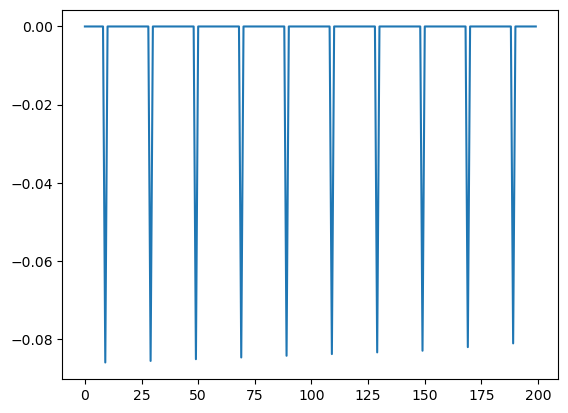

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0089, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0088, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000]) tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0909, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0899, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
tensor([-0.6281, -0.6283, -0.6285,  ...,  0.0000,  0.0000,  0.0000])
tensor([-0.6281, -0.6283, -0.6285,  ...,  0.0000,  0.0000,  0.0000])


tensor(0.4242)

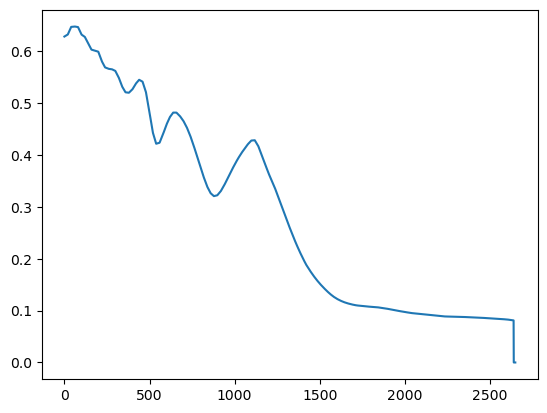

In [162]:
half = torch.zeros((len(wavelengths),))
half[wavelengths < 1.7] += .5
fig = "untracked-figures/grid_search/twisted-squares_0.07630828937395717_0.4384092314408935"
forward = torch.load(f'../{fig}_forward.pt')
backward = torch.load(f'../{fig}_backward.pt')
l = 200
plt.plot(forward[-l:] - backward[-l:])
plt.show()
print(forward[-40:], backward[-40:])
interpolated_half = interpolate_sparse_tensor(forward - backward)
print(interpolated_half)
interpolated_half = torch.tensor([interpolated_half[i] for i in range(len(interpolated_half)) if i not in [150, 650]])
print(interpolated_half)
plt.plot(-interpolated_half)
ff.power_ratio(wavelengths, -interpolated_half, ff.T_e, .726)

/tmp/ipykernel_4362/2280246019.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forward = torch.load(forward_path)
/tmp/ipykernel_4362/2280246019.py:42: FutureWarning: Y

tensor([-0.5014, -0.5010, -0.5005,  ...,  0.0000,  0.0000,  0.0000])
Processing figure 0.010374153885699955_0.4957732931341461:
Power ratio for figure 0.010374153885699955_0.4957732931341461: 0.36020180583000183
tensor([-0.6281, -0.6283, -0.6285,  ...,  0.0000,  0.0000,  0.0000])
Processing figure 0.07630828937395717_0.4384092314408935:
Power ratio for figure 0.07630828937395717_0.4384092314408935: 0.424181193113327
tensor([-0.6094, -0.6097, -0.6100,  ...,  0.0000,  0.0000,  0.0000])
Processing figure 0.1802696888767692_0.4632185264983446:
Power ratio for figure 0.1802696888767692_0.4632185264983446: 0.4392639398574829
tensor([-0.4503, -0.4490, -0.4477,  ...,  0.0000,  0.0000,  0.0000])
Processing figure 0.22199317108973948_0.20671915533942642:
Power ratio for figure 0.22199317108973948_0.20671915533942642: 0.38001197576522827
tensor([-5.7220e-06, -5.8919e-06, -6.0618e-06,  ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00])
Processing figure 0.417022004702574_0.00011437481734488664:


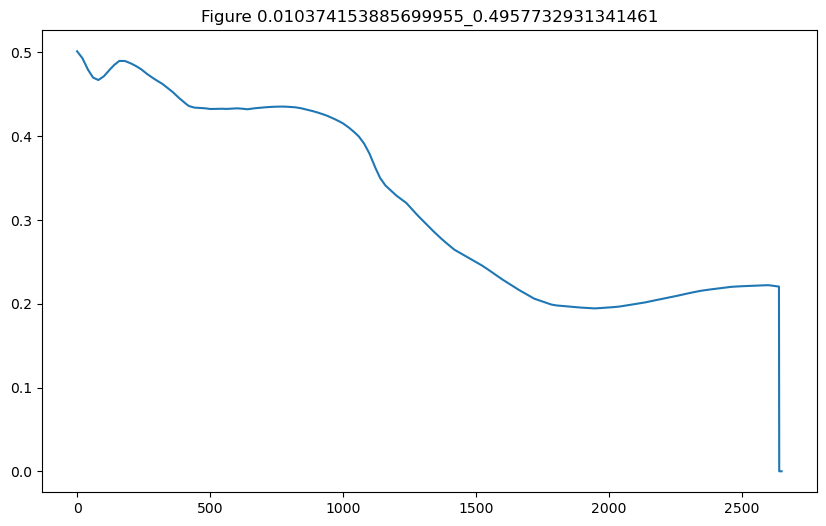

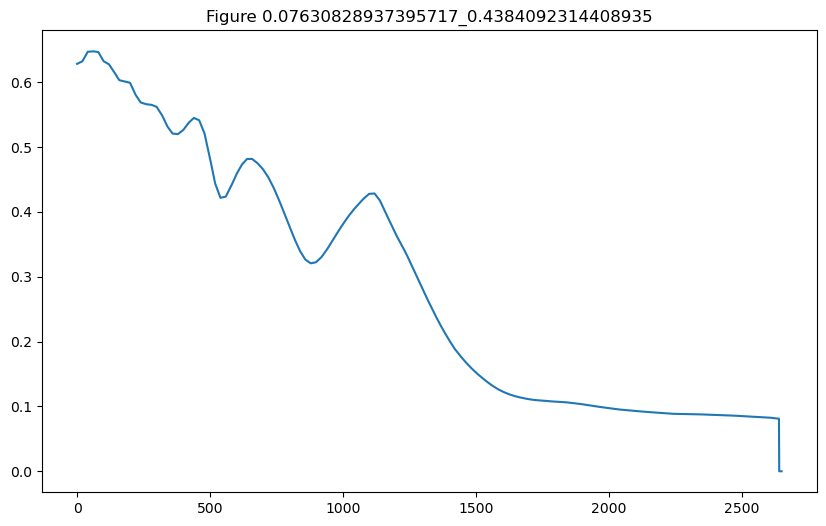

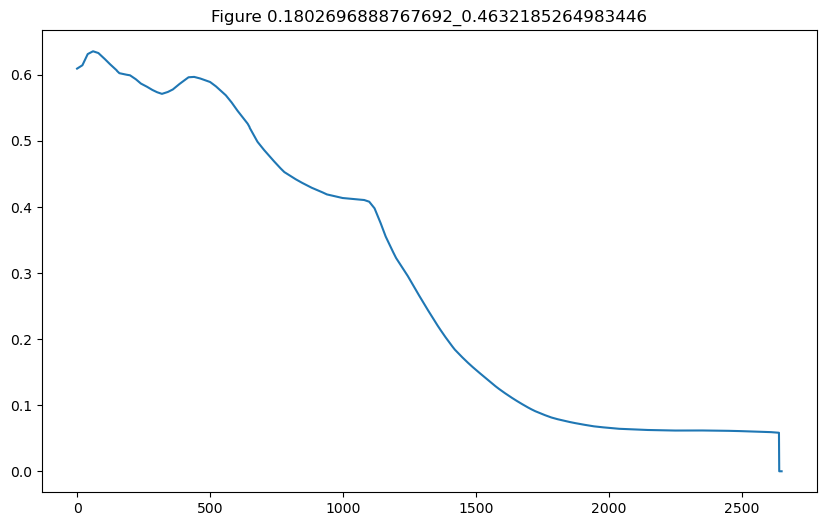

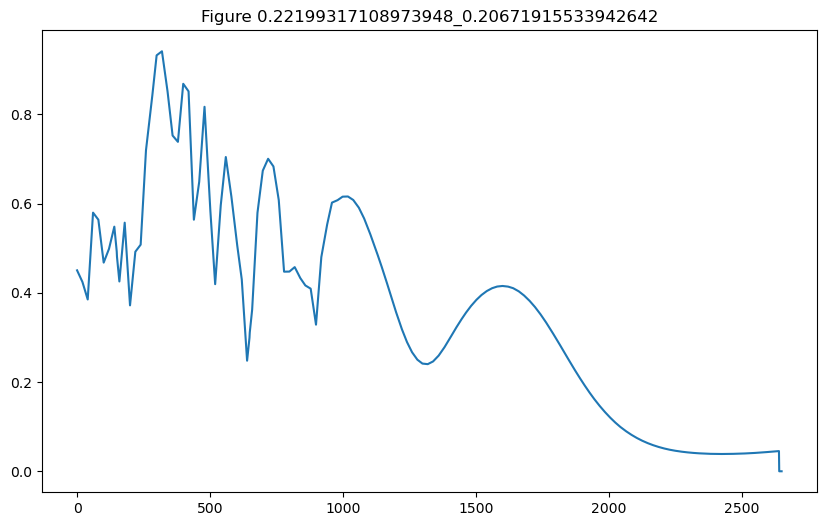

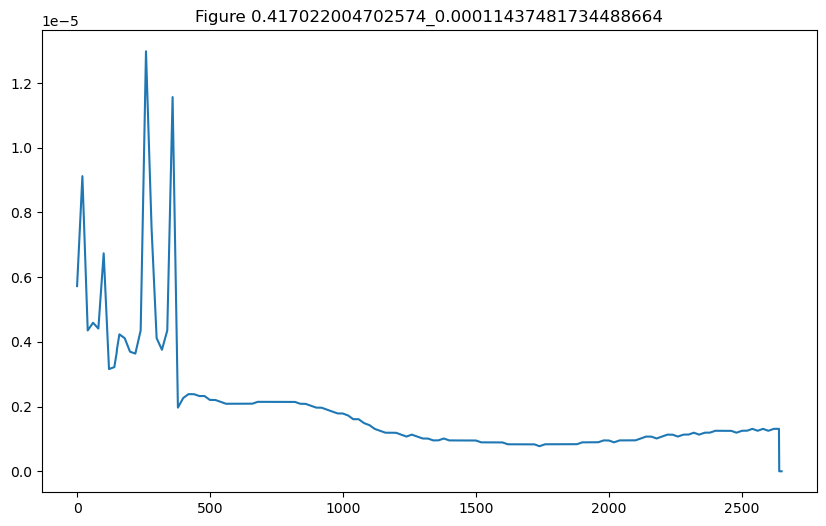

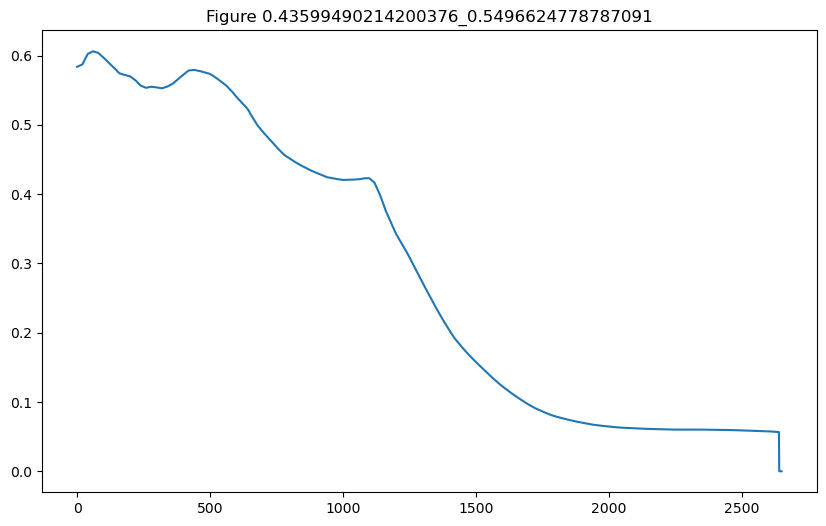

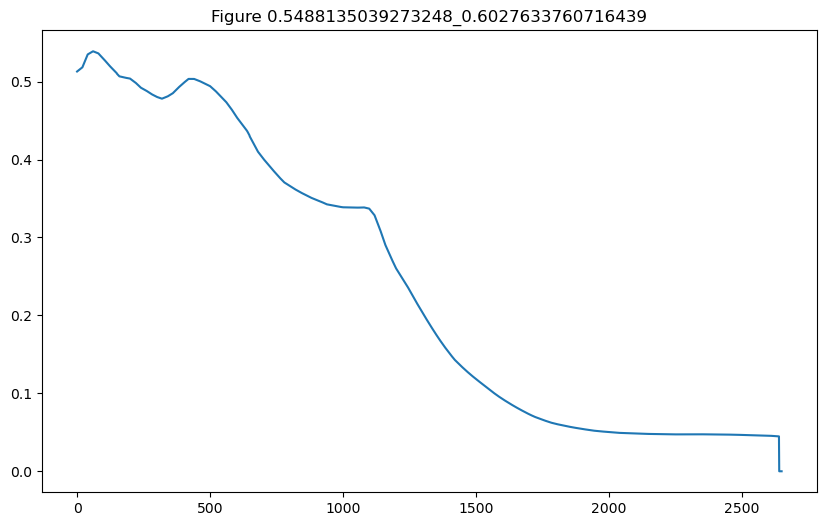

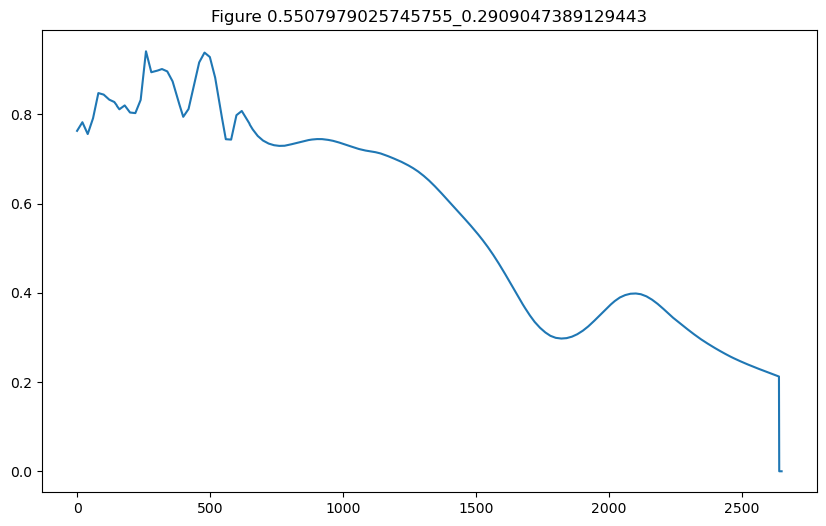

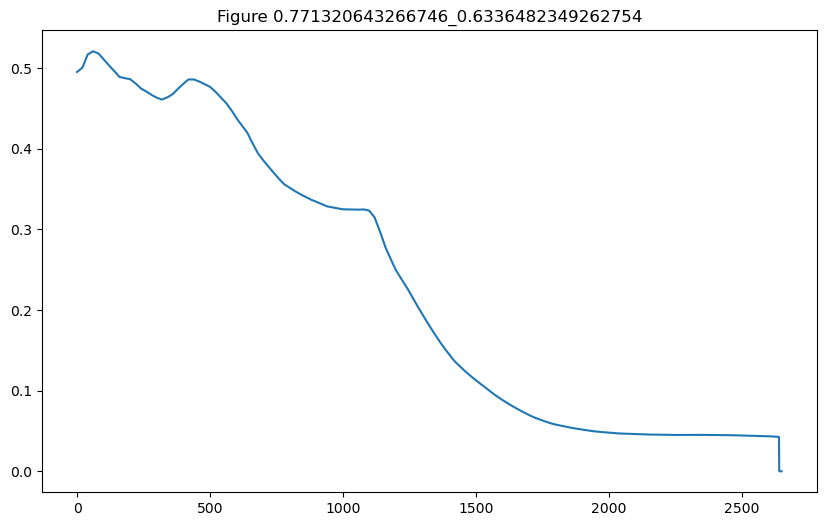

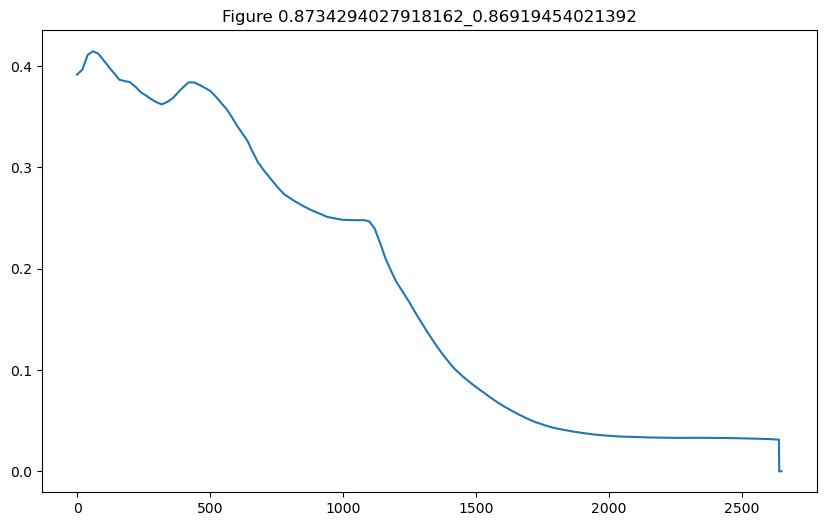

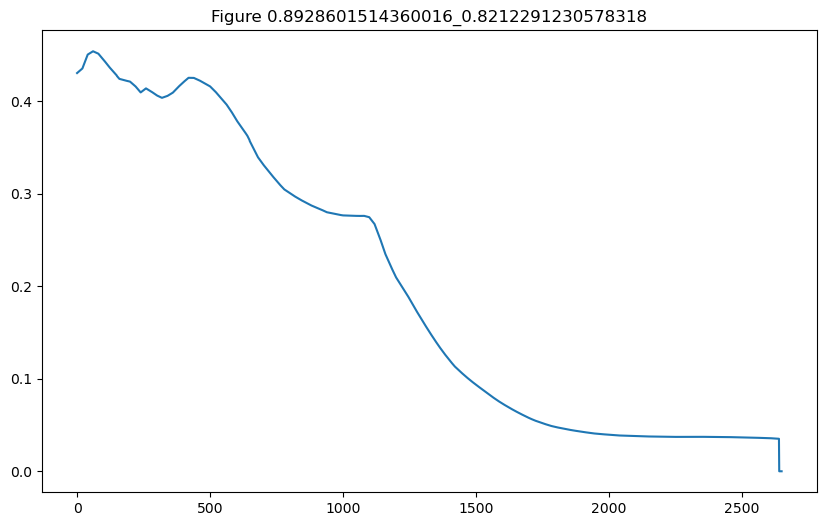

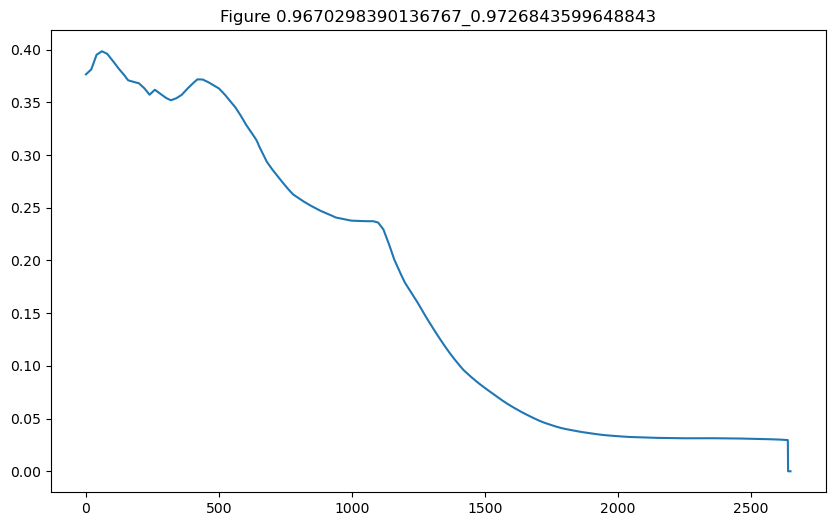

In [153]:
import os
import torch
import matplotlib.pyplot as plt
import ff
import re

# Get wavelengths (assuming this is defined elsewhere in your code)
wavelengths = torch.linspace(.350, 3, 2651)
wavelengths = wavelengths[(wavelengths != 0.5) & (wavelengths != 1.0)]

# Get all unique figure identifiers from the directory
base_dir = '../untracked-figures/grid_search/'
all_files = os.listdir(base_dir)
figure_ids = set()

# Pattern to match: twisted-squares_<float1>_<float2>_forward.pt or backward.pt
pattern = re.compile(r'twisted-squares_([\d\.]+)_([\d\.]+)_(forward|backward)\.pt')

for filename in all_files:
    match = pattern.match(filename)
    if match:
        num1, num2 = match.group(1), match.group(2)
        figure_ids.add(f"{num1}_{num2}")

# Create output directory if it doesn't exist
os.makedirs('analysis_results', exist_ok=True)

# Process each figure
results = []
for fig in sorted(figure_ids):
    try:
        # Create the half tensor
        half = torch.zeros((len(wavelengths),))
        half[wavelengths < 1.7] += .5
        
        # Load the forward and backward data
        forward_path = f'{base_dir}twisted-squares_{fig}_forward.pt'
        backward_path = f'{base_dir}twisted-squares_{fig}_backward.pt'
        
        if os.path.exists(forward_path) and os.path.exists(backward_path):
            forward = torch.load(forward_path)
            backward = torch.load(backward_path)
            
            # Process the data
            interpolated_half = interpolate_sparse_tensor(forward - backward)
            interpolated_half = torch.tensor([interpolated_half[i] for i in range(len(interpolated_half)) 
                                             if i not in [150, 650]])
            print(interpolated_half)
            # Print results
            print(f"Processing figure {fig}:")
            
            # Plot the data
            plt.figure(figsize=(10, 6))
            plt.plot(-interpolated_half)
            plt.title(f"Figure {fig}")
            # plt.savefig(f'analysis_results/figure_{fig}_plot.png')
            # plt.close()
            
            # Calculate power ratio
            power_ratio = ff.power_ratio(wavelengths, -interpolated_half, ff.T_e, .726)
            print(f"Power ratio for figure {fig}: {power_ratio}")
            
            # Store results
            results.append((fig, power_ratio))
            
    except Exception as e:
        print(f"Error processing figure {fig}: {e}")

# Save all results sorted by power ratio
results.sort(key=lambda x: x[1], reverse=True)
# with open('analysis_results/power_ratios.txt', 'w') as f:
#     f.write("Figure ID, Power Ratio\n")
#     for fig, ratio in results:
#         f.write(f"{fig}, {ratio}\n")

print("Analysis complete!")


/tmp/ipykernel_4362/3792645059.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


Not flipped
Not flipped
Flipped
Flipped
Not flipped
Flipped
Flipped
Flipped
Not flipped
Not flipped
Not flipped
Flipped
Not flipped
Not flipped
Flipped
Flipped
Flipped
Not flipped
Flipped
Flipped
Not flipped
Not flipped
Flipped
Not flipped
Loaded 24 .pt files


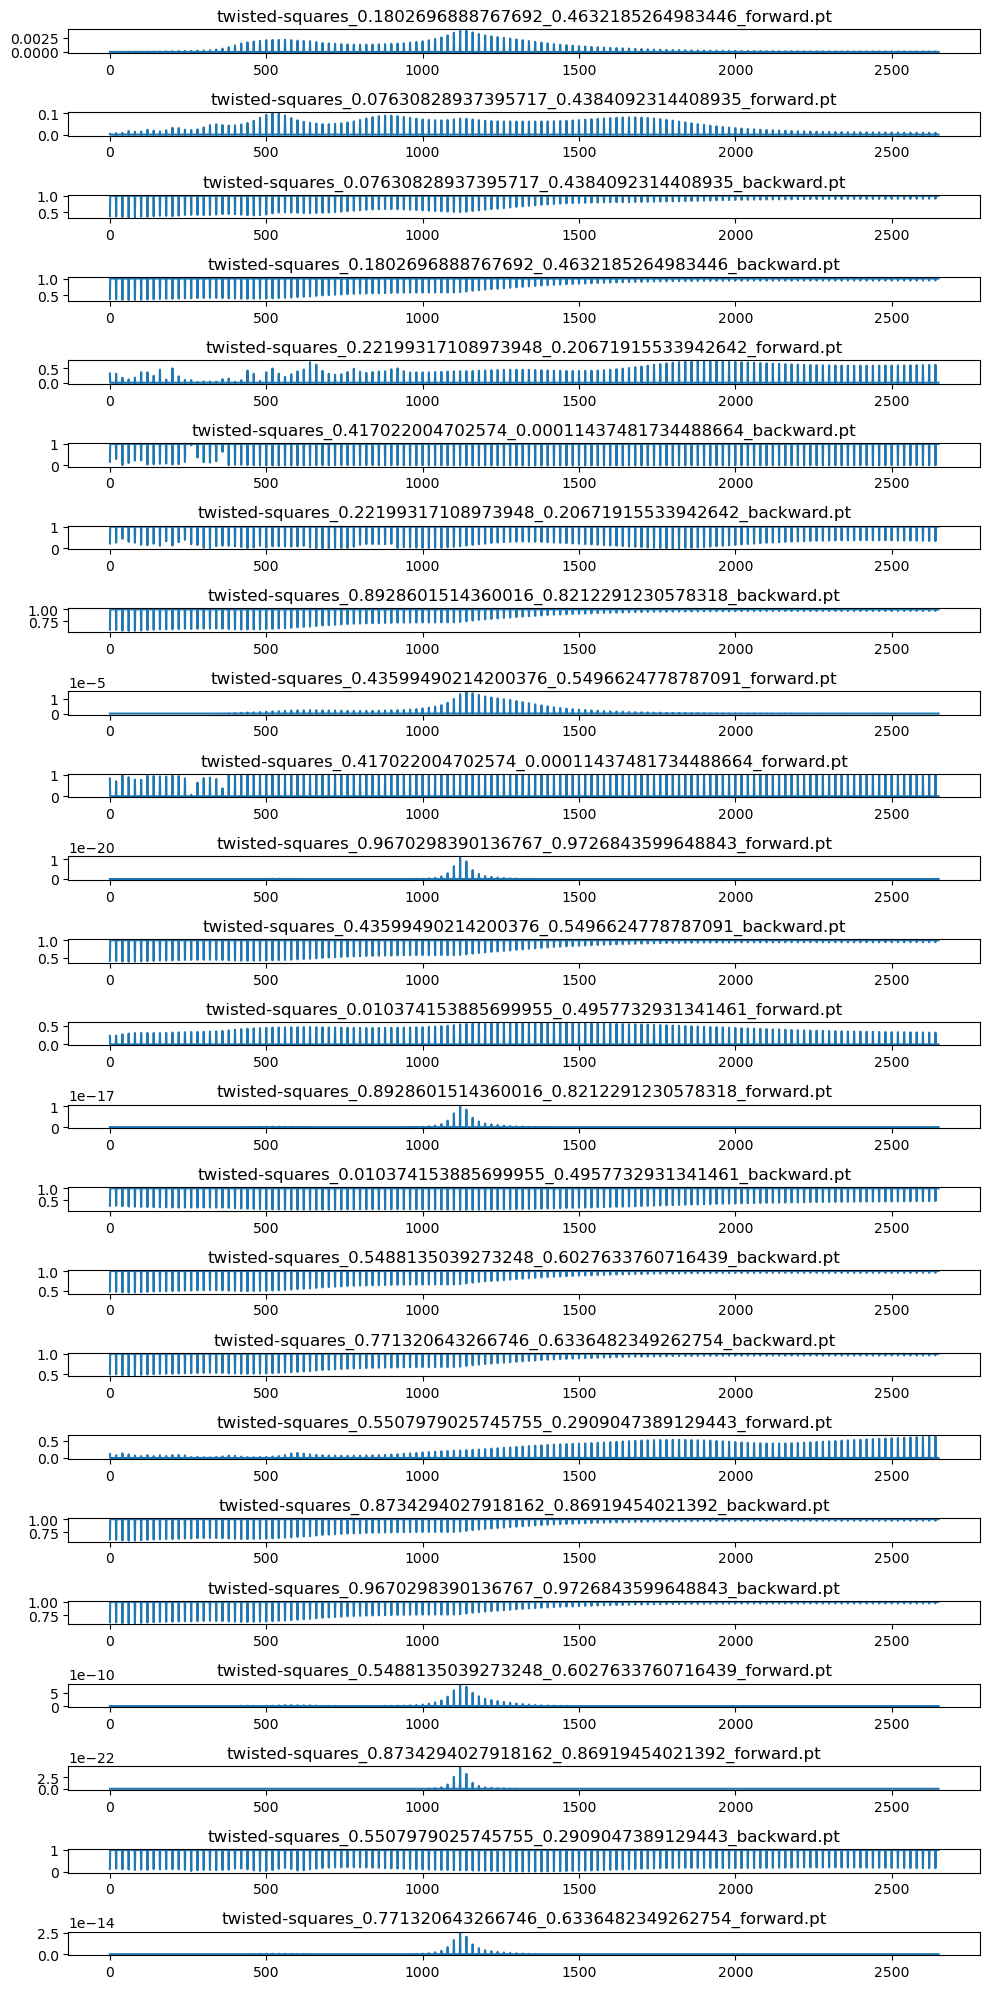

In [133]:
import torch
import os
import glob
from pathlib import Path

# Path to the untracked-figures directory
untracked_figures_dir = "../untracked-figures/grid_search"

# Find all .pt files in the directory
pt_files = glob.glob(os.path.join(untracked_figures_dir, "*.pt"))

# Load all .pt files into a list
loaded_data = []
for file_path in pt_files:
    try:
        data = torch.load(file_path)
        # Store as tuple with filename and data
        filename = Path(file_path).name
        if "twisted" not in filename:
            continue
        if "backward" in filename:
            loaded_data.append((filename, 1-data))
            print("Flipped")
        elif "forward" in filename:
            loaded_data.append((filename, data))
            print("Not flipped")
        # print(f"Loaded: {filename}")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

print(f"Loaded {len(loaded_data)} .pt files")

# If you want to visualize some of the data
import matplotlib.pyplot as plt

# Plot the first few loaded tensors
fig, axes = plt.subplots(len(loaded_data), 1, figsize=(10, 20))
for i, (filename, data) in enumerate(loaded_data):
    if len(loaded_data) > 1:
        ax = axes[i]
    else:
        ax = axes
    ax.plot(data.cpu().numpy())
    ax.set_title(filename)
    
plt.tight_layout()
plt.show()


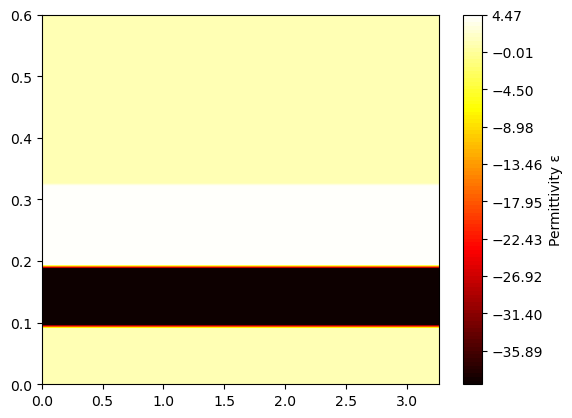

In [102]:
import S4
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
thickness0, thickness1, radius_min, radius_max = np.random.rand(4)

S = S4.New(Lattice = ((.6, 0), (0,.6)), NumBasis=50)
S.SetOptions(LanczosSmoothing=True)
S.SetMaterial(Name='Vacuum', Epsilon=(1+0j)**2)
S.SetMaterial(Name='W', Epsilon=(ff.w_n[i_wavelength])**2)    # Simple approximate usage
S.SetMaterial(Name='AlN', Epsilon=(ff.aln_n[i_wavelength])**2)
S.AddLayer(Name = 'VacuumAbove', Thickness = .5, Material = 'Vacuum')
S.AddLayer(Name = 'Grid0', Thickness = thickness0, Material = 'W')
S.SetRegionCircle(Layer = 'Grid0', Material = f'W', Center = (.3, .3), Radius = max(radius_min, radius_max) * .3)
S.AddLayer(Name = 'Grid1', Thickness = thickness1, Material = 'AlN')
S.SetRegionCircle(Layer = 'Grid1', Material = f'AlN', Center = (.3, .3), Radius = max(radius_min, radius_max) * .3)
S.AddLayer(Name = 'VacuumBelow', Thickness = .5, Material = 'Vacuum')

S.SetFrequency(1 / wavelength)
S.SetExcitationPlanewave(IncidenceAngles=(config['incidence_angle'], 0), sAmplitude=np.cos(config['polarization_angle']*np.pi/180), pAmplitude=np.sin(config['polarization_angle']*np.pi/180), Order=0) # In the real simulation this should be edited to have 1/sqrt(2) amplitude in both directions

x_space = np.linspace(0, .6, 100)
y_pt = 0.3
z_min = 0
z_max = 1 + thickness1 + thickness0 + 0.5 + 0.5
z_space = np.linspace(z_min, z_max, 100)
eps = np.zeros((len(z_space), len(x_space)), dtype=complex)
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        eps[zi, xi] = S.GetEpsilon(x, y_pt, z)
contour = plt.contourf(z_space, x_space, eps, levels = np.linspace(np.min(eps), np.max(eps), 100), cmap = 'hot')
plt.colorbar(contour, label='Permittivity ε')